In [106]:
import numpy as np
import decentralized as dec
from time import perf_counter as pc
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from decentralized import split_agents, plot_solve
import decentralized as dec
import pocketknives

π = np.pi
g = 9.80665

In [116]:
import do_mpc

In [199]:
data_baseline = np.load('drone_sim_data.npy')

In [200]:
dataSet = data_baseline
# print(dataSet)
dataSet = np.array(dataSet).T

In [201]:
dataSet.shape

(18, 51)

In [202]:
%matplotlib ipympl

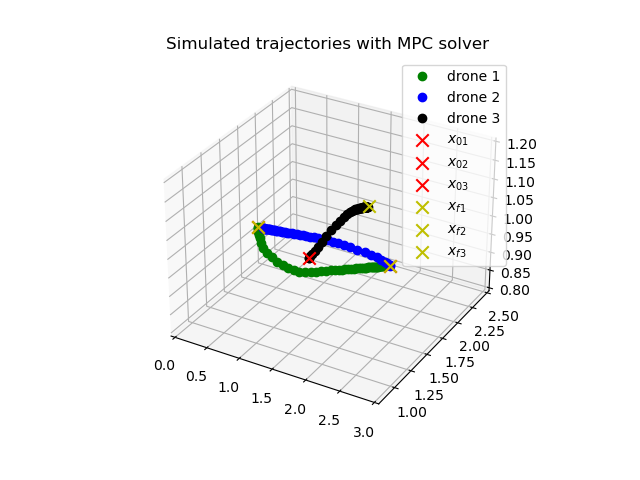

In [217]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

 
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = plt.gcf().add_subplot(projection="3d")
ax.plot(dataSet[0], dataSet[1], dataSet[2], 'go',label='drone 1')
ax.plot(dataSet[6], dataSet[7], dataSet[8], 'bo',label='drone 2')
ax.plot(dataSet[12], dataSet[13], dataSet[14], 'ko',label='drone 3')
ax.scatter(0.5,1.5,1,s=80, c="r",marker="x",label='$x_{01}$')
ax.scatter(2.5,1.5,1,s=80, c="r",marker="x",label='$x_{02}$')
ax.scatter(1.5,1.3,1,s=80, c="r",marker="x",label='$x_{03}$')

ax.scatter(2.5,1.5,1,s=80, c="y",marker="x",label='$x_{f1}$')
ax.scatter(0.5,1.5,1,s=80, c="y",marker="x",label='$x_{f2}$')
ax.scatter(1.5,2.2,1,s=80, c="y",marker="x",label='$x_{f3}$')
ax.set_xlim(0,3)
ax.set_ylim(0.8,2.5)
ax.set_zlim(0.8,1.2)
plt.legend(loc='best')
plt.title('Simulated trajectories with MPC solver')
plt.savefig('plots/3_drone_nlmpc.png')


In [78]:
plt.clf()

In [182]:
# #velocity components:
# fig = plt.figure()
# ax = Axes3D(fig,auto_add_to_figure=False)
# fig.add_axes(ax)
# ax.plot(dataSet[3], dataSet[4], dataSet[5], 'go',label='drone 1')
# ax.plot(dataSet[9], dataSet[10], dataSet[11], 'bo',label='drone 2')
# ax.plot(dataSet[15], dataSet[16], dataSet[17], 'ko',label='drone 3')
# ax.legend()

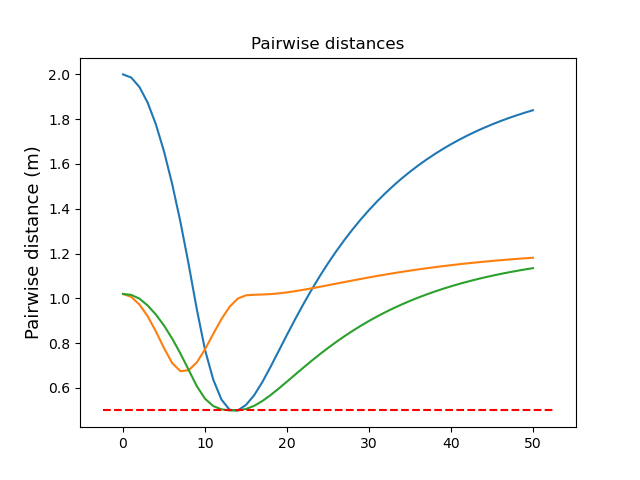

In [208]:
plt.figure()
x_dims = [6,6,6]
radius = 0.5
plt.plot(dec.compute_pairwise_distance(dataSet.T, x_dims, 3))
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
# plt.title('Distance between human and quad over entire horizon')
plt.ylabel('Pairwise distance (m)',fontsize=13)
plt.title('Pairwise distances')
plt.draw()

In [157]:
data_baseline[0]

array([0.5, 1.5, 1. , 0. , 0. , 0. , 2.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
       1.3, 1. , 0. , 0. , 0. ])

In [158]:
data_baseline[-1]

array([ 2.429e+00,  1.473e+00,  1.000e+00,  9.542e-02,  3.878e-02,
       -1.484e-09,  5.799e-01,  1.507e+00,  1.000e+00, -1.072e-01,
       -1.023e-02, -1.484e-09,  1.491e+00,  2.193e+00,  1.000e+00,
        1.180e-02,  9.749e-03, -1.484e-09])

### Using potential iLQR:

In [209]:
def paper_setup_3_quads():
    x0 = np.array([[0.5, 1.5, 1, 0, 0, 0,
                    2.5, 1.5, 1, 0, 0, 0,
                    1.5, 1.3, 1, 0, 0, 0]], 
                     dtype=float).T
    xf = np.array([[2.5, 1.5, 1, 0, 0, 0, 
                    0.5, 1.5, 1, 0, 0, 0, 
                    1.5, 2.2, 1, 0, 0, 0]]).T
    
    return x0, xf

In [210]:
n_agents = 3
n_states = 6
n_controls = 3

x_dims = [n_states] * n_agents
u_dims = [n_controls] * n_agents
n_dims = [3,3,3]

dt = 0.05
N = 15
radius = 0.5

x0, xf = paper_setup_3_quads()

Q = np.diag([1, 1, 1, 5, 5, 5])
R = np.diag([1, 1, 1])
Qf = 1e3 * np.eye(n_states)

Qs = [Q] * n_agents
Rs = [R] * n_agents
Qfs = [Qf] * n_agents


models = [dec.QuadcopterDynamics6D,dec.QuadcopterDynamics6D,dec.QuadcopterDynamics6D]
ids = [100 + i for i in range(n_agents)]
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_, model in zip(ids, models)])

goal_costs = [
    dec.ReferenceCost(xf_i, Qi, Ri, Qfi, id_)
    for xf_i, id_, x_dim, Qi, Ri, Qfi in zip(
        dec.split_agents_gen(xf, x_dims), ids, x_dims, Qs, Rs, Qfs
    )
]
prox_cost = dec.ProximityCost(x_dims, radius, n_dims)
game_cost = dec.GameCost(goal_costs, prox_cost)
problem = dec.ilqrProblem(dynamics, game_cost)
solver = dec.ilqrSolver(problem, N)

g = 9.81
U0 = np.tile([g, 0, 0], (N, n_agents))

In [211]:
x0

array([[0.5],
       [1.5],
       [1. ],
       [0. ],
       [0. ],
       [0. ],
       [2.5],
       [1.5],
       [1. ],
       [0. ],
       [0. ],
       [0. ],
       [1.5],
       [1.3],
       [1. ],
       [0. ],
       [0. ],
       [0. ]])

In [212]:
xf

array([[2.5],
       [1.5],
       [1. ],
       [0. ],
       [0. ],
       [0. ],
       [0.5],
       [1.5],
       [1. ],
       [0. ],
       [0. ],
       [0. ],
       [1.5],
       [2.2],
       [1. ],
       [0. ],
       [0. ],
       [0. ]])

In [103]:
X_rhc, U_rhc, J_rhc = dec.solve_rhc(
    problem, x0,  N, radius,
    centralized=True,
    n_d=3,
    step_size=1, 
    dist_converge=0.1,
    verbose=True,
    t_kill=2*dt,
    t_diverge=None
)

t: 0
t: 0.05
t: 0.1
t: 0.15
t: 0.2
t: 0.25
t: 0.3
t: 0.35
t: 0.4
t: 0.45
t: 0.5
t: 0.55
t: 0.6
t: 0.65
t: 0.7
t: 0.75
t: 0.8
t: 0.85
t: 0.9
t: 0.95
t: 1
t: 1.05
t: 1.1
t: 1.15
t: 1.2
t: 1.25
t: 1.3
t: 1.35
t: 1.4
t: 1.45
t: 1.5
t: 1.55
t: 1.6
t: 1.65
t: 1.7
t: 1.75
t: 1.8
t: 1.85
t: 1.9
t: 1.95
t: 2
t: 2.05
t: 2.1
t: 2.15
t: 2.2
t: 2.25


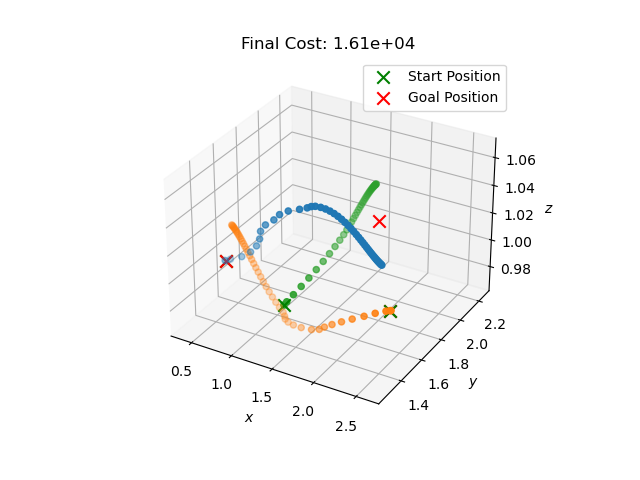

In [214]:
plt.clf()
plt.figure()
dec.util.plot_solve(X_rhc, J_rhc, xf,x_dims, True, n_d=3)
ax = plt.gca()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.savefig('plots/3_drone_iLQR.png')
plt.draw()